# TP3: Model Free

### Description: 

In this session, we are exploring a simple version of a game
(simpler version of Perudo: https://www.youtube.com/watch?v=die0n-eonl8).
Using the rules of the game, we first construct an environment. 
  
There is below a simple code where the game is played using a random statregy.

Also, there are two functions to display the optimal value functions and optimal policies.


### TO DO:

1) Implement MC, SARSA, Q-learning to learn the value function. It is recommended to use the indications of code below.


2) For the 3 cases, display the value function and the optimal policy found. 


Bonus track (Facultative)

3) Create a new environment which takes as parameter a given policy. Then implement iterations where you find the optimal value function for a given adversarial policy and then you play in turn against this policy.
Display the results after some iterations. Comment.

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 


In [ ]:
import gym
import numpy as np
import random
from gym import spaces
from gym.utils import seeding
from tqdm.notebook import tqdm

THE GAME

**Rules**:

- 2 players 
- Each player has 5 coins (head or tail). Each player only sees her coins.  
- After flipping each coin, the game starts.
- The game consists in guessing how many heads are present between all coins (or make the other player guess wrongly).
- Bets start at 0 head.
- The starting player is chosen at random. (Flip a coin)
- Possible actions:
    * the player keeps the actual bet and passes.
    * the player add 1 to the actual bet (estimate of the total number of heads).
- The game stops when one player passes.
- if the bet is strictly bigger than the real number, the last player to play looses (r=-1) and the other wins (r=1). if the bet is smaller or equal, the last player wins (r=1) and the other looses (r=-1).
- IA initialisation of the computer strategy: if the bet  is smaller than 2+ quantity of observed own heads, bets, otherwise passes.

In [ ]:
# Environment and rules

def throw_coin(num_coin, np_random):
    return np_random.rand(num_coin)>0.5

def total_faces(list_players):
    RV=0
    for player in list_players:
        RV += sum(player)
    return RV

class PerudoSimplificado(gym.Env):
    def __init__(self):
        
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(5), #mis monedas
            spaces.Discrete(10))) #apuesta actual

        self.seed()
        # Empieza el juego
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        
        max_guess_player_2 = total_faces([self.player_2]) + int(len(self.player_1)/2)
        faces_tot = total_faces([self.player_1, self.player_2])
        
        if self.guess > len(self.player_1) + len(self.player_2): #the bet is bigger than the max possible
            done = True
            reward = -1

        if action == 0: #action == 0, maintain the bet and pass 
            done = True
            if self.guess <= faces_tot: #the other player was right
                reward = -1
            else: #I was right
                reward = 1
            
        else: #action == 1, add 1 in the bet 
            self.guess += 1
            if self.guess < max_guess_player_2: # the other player adds 1
                self.guess += 1 
                done = False
                reward = 0
            else: # other player passes
                done = True
                if self.guess <= faces_tot: 
                    reward = 1
                else:
                    reward = -1
            
        return self.get_obs(), reward, done, {}

    def get_obs(self):
        return (sum(self.player_1), self.guess)
    
    def reset(self):
        self.player_1 = throw_coin(5,self.np_random)
        self.player_2 = throw_coin(5,self.np_random)
        self.guess = 1 if np.random.rand()>0.5 else 0 # flip a coin to see who starts.
        return self.get_obs()

## Playing at random

In [ ]:
env = PerudoSimplificado()
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(5), Discrete(10))
Discrete(2)


In [ ]:
#Politica Random:
for i_episode in range(20):
    state = env.reset()
    while True:
        action = env.action_space.sample() # Selects a random action 
        state, reward, done, info = env.step(action) # Plays one round
        print(state,action)
        if done:
            print('Game over! Your reward: ', reward)
            print('You win :)\n') if reward > 0 else print('You lost:(\n')
            break

## Plots:

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_values(V):
    """
    Does a 3D display of the value function.
        
    The parameter V describes the value function in function of the number of "heads in your hand"
    and "actual bet".
    """
    def get_Z(x, y):
        if (x,y) in V:
            return V[x,y]
        else:
            return 0

    def get_figure(ax):
        x_range = np.arange(0, 6)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('heads')
        ax.set_ylabel('bets')
        ax.set_zlabel('value')
        ax.view_init(ax.elev, -120)
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    get_figure(ax)
    plt.show()

In [ ]:
def plot_policy(policy):
    """
    3D graphic of value function.
    
     policy is a function of "heads" 
     and "bets" and the value is the action to be realized.
    """
    def get_Z(x, y):
        if (x,y) in policy:
            return policy[x,y]
        else:
            return 25 # this value is to vizualize that there is no action yet defined for this state
             

    def get_figure( ax):
        x_range = np.arange(0, 6)
        y_range = np.arange(0, 11)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y) for x in x_range] for y in y_range])
        surf = ax.imshow(np.flip(Z,0), cmap=plt.get_cmap('Pastel2', 3), vmin=0, vmax=2, extent=[-0.5, 5.5, -0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('heads')
        ax.set_ylabel('bets')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1,2], cax=cax)
        cbar.ax.set_yticklabels(['0 (pass)','1 (up)', 'unknown'])
        print(Z)
            
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    get_figure(ax)
    plt.show()

## Monte Carlo

In [ ]:
from collections import defaultdict

In [ ]:
def get_probs(Q_s, epsilon, nA): 
    best_action = np.argmax(Q_s)
    policy_s = np.array([ 1-epsilon + epsilon/nA if a==best_action else epsilon/nA for a in range(nA)])
    return policy_s
  

def generate_episode_from_Q(env, Q, epsilon, nA):
    episode = []
    current_state = env.reset()
    while True :
        prob_scores = get_probs(Q[current_state], epsilon , nA)
        selected_action = np.random.choice (np.arange(nA),p = prob_scores)
        next_state, reward, done, _ = env.step(selected_action)
        episode.append((current_state,selected_action,reward))
        if done : 
           break 
        current_state = next_state
    return episode


def update_Q(env, episode, Q, alpha ):
    G=0
    for i in reversed(range(len(episode))) :
        state,action,reward = episode[i]
        state_action = (state,action)
        G+=reward
        if state_action not in [(sar[0],sar[1]) for sar in episode[:i]] : ## first occurence
           value_state = Q[state][action] 
           Q[state][action] =  value_state + alpha * (G - value_state )
        
    return Q

In [ ]:
def mc_control(env, num_episodes, alpha, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    
    nA = env.action_space.n
    Q = defaultdict(lambda : np.zeros(nA))
    epsilon = eps_start
    for _ in tqdm(range(num_episodes)): 
        episode = generate_episode_from_Q(env, Q, epsilon, nA )
        Q = update_Q(env, episode, Q, alpha)
        epsilon *= eps_decay
        epsilon = max(epsilon , eps_min)

    policy = {}
    for state,actions in Q.items():
        policy[state] = np.argmax(actions) ## we suppose that we only do exploitation now since we explored enough the different possibilites

    return policy, Q

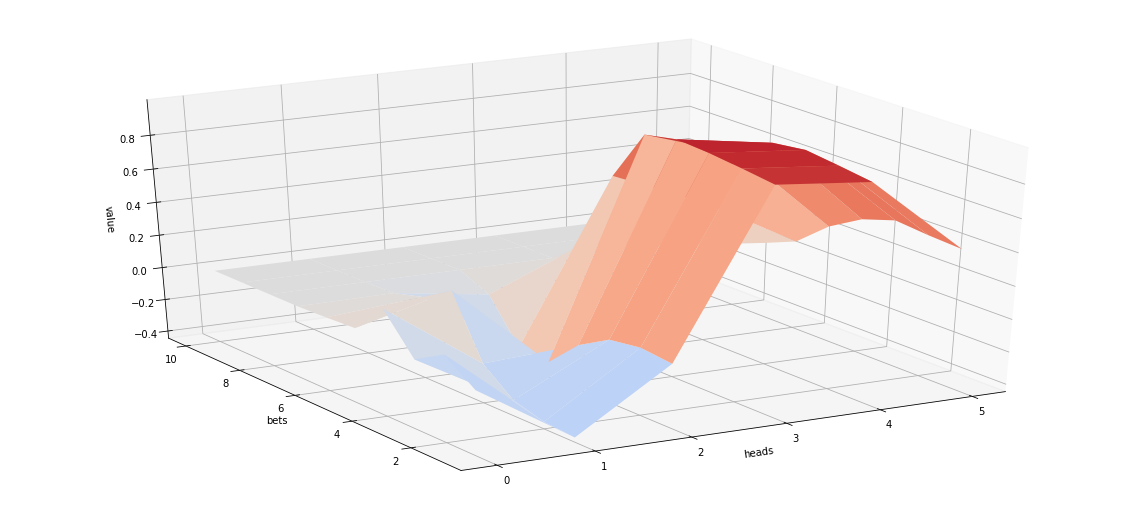

In [ ]:
# Compute  the optimal policy and value function
policy, Q = mc_control(env, 500000,0.0001)
V = dict((k,np.max(v)) for k, v in Q.items())
plot_values(V)

[[ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 0  1  1  1  1  1]
 [ 0  0  1  1  1  1]
 [ 0  0  1  1  1  1]
 [ 0  0  1  1  1  1]
 [ 0  0  1  1  1  1]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]]


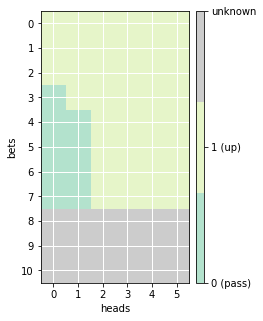

In [ ]:
# plot the policy
plot_policy(policy)

## SARSA

In [ ]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    
    value_state = Q[state][action] 
    Q[state][action] =  value_state + alpha * (reward + gamma * Q[next_state][next_action]  - value_state )
    return Q

def epsilon_greedy(Q, state, nA, eps):
     
    best_action = np.argmax(Q[state])
    policy_s = np.array([ 1-eps + eps/nA if a==best_action else eps/nA for a in range(nA)])
    return policy_s

def generate_episode_sarsa (env, Q, epsilon, nA  , alpha , gamma) :
    episode = []
    current_state = env.reset()
    prob_scores = epsilon_greedy(Q, current_state , nA, epsilon )
    first_action = np.random.choice (np.arange(nA),p = prob_scores)
    while True :

        next_state, reward, done, _ = env.step(first_action)
        
        second_prob_scores = epsilon_greedy(Q, next_state , nA, epsilon)
        second_action = np.random.choice (np.arange(nA),p = second_prob_scores)
        Q = update_Q_sarsa(alpha , gamma , Q , current_state , first_action,
                           reward , next_state , second_action)
        if done : 
           break 
        current_state = next_state
        first_action = second_action
    return Q

In [ ]:
def sarsa(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda : np.zeros(nA))
    epsilon = eps_start
    for i in tqdm(range(num_episodes)): 
        Q = generate_episode_sarsa(env, Q, epsilon, nA  , alpha , gamma)
        epsilon = epsilon/(i + 1) if epsilon/(i + 1) > eps_min else eps_min

    return Q
    

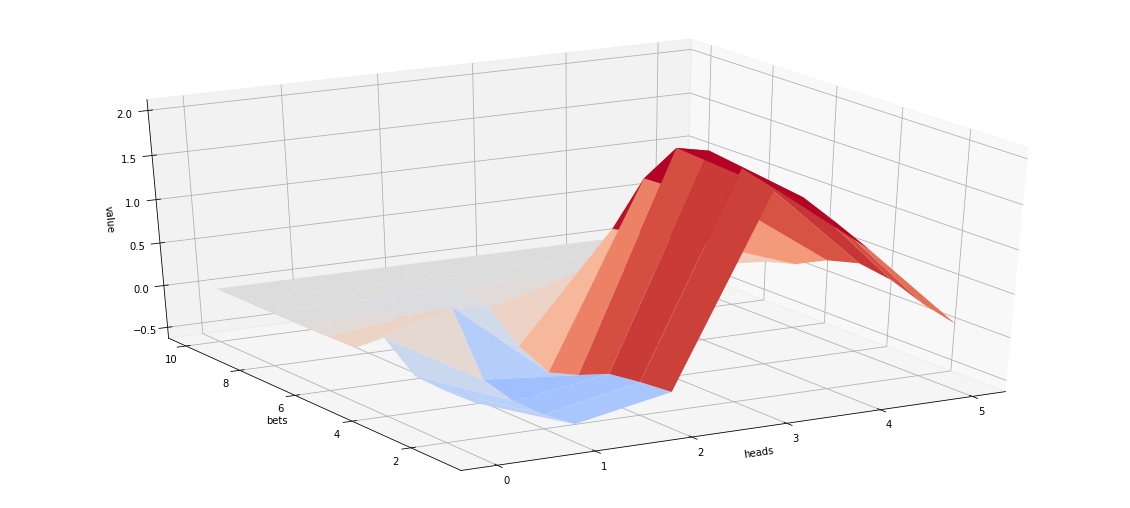

In [ ]:
# Compute  the optimal policy and value function
Q_sarsa = sarsa(env, 500000, 0.0001)
V = dict((k,np.max(v)) for k, v in Q_sarsa.items())
plot_values(V)

[[ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 0  1  1  1  1  1]
 [ 0  0  1  1  1  1]
 [ 0  0  1  1  1  1]
 [ 0  0  1  1  1  1]
 [ 0  0  0  1  1  1]
 [25 25  0  0  0  0]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]]


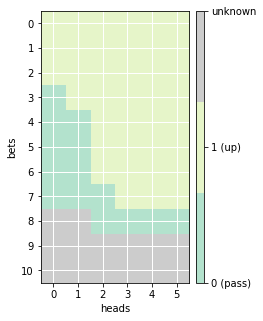

In [ ]:
# plot
policy_sarsa = dict((k,np.argmax(v)) for k, v in Q_sarsa.items())
plot_policy(policy_sarsa)

## Q-learning

In [ ]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    next_action = np.argmax(Q[next_state])
    value_state = Q[state][action] 
    Q[state][action] =  value_state + alpha * (reward + gamma * Q[next_state][next_action]  - value_state )
    return Q

def epsilon_greedy(Q, state, nA, eps):
     
    best_action = np.argmax(Q[state])
    policy_s = np.array([ 1-eps + eps/nA if a==best_action else eps/nA for a in range(nA)])
    return policy_s

def generate_episode_qlearning (env, Q, epsilon, nA  , alpha , gamma) :
    episode = []
    current_state = env.reset()
    
    while True :

        prob_scores = epsilon_greedy(Q, current_state , nA, epsilon )
        first_action = np.random.choice (np.arange(nA),p = prob_scores)
        next_state, reward, done, _ = env.step(first_action)
        Q = update_Q_sarsamax(alpha , gamma , Q , current_state , first_action,
                           reward , next_state )
        if done : 
           break 
        current_state = next_state
    return Q

In [ ]:
def q_learning(env, num_episodes, alpha, gamma=1.0, eps_start = 1 , epsmin=0.01):
    
    nA = env.action_space.n
    Q  = defaultdict(lambda : np.zeros(nA))
    epsilon = eps_start
    for i in tqdm(range(num_episodes)): 
        Q = generate_episode_qlearning(env, Q, epsilon, nA  , alpha , gamma)
        epsilon = epsilon/(i + 1) if epsilon/(i + 1) > epsmin else epsmin

    return Q

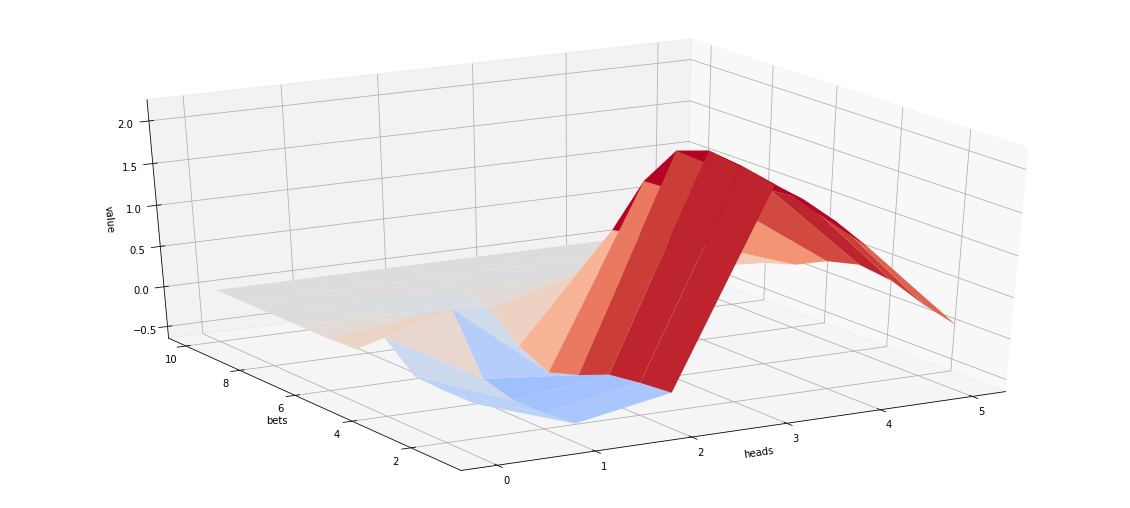

In [ ]:
# Compute  the optimal policy and value function
Q_sarsamax = q_learning(env, 500000, 0.0001)
V = dict((k,np.max(v)) for k, v in Q_sarsamax.items())
plot_values(V)

[[ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 0  1  1  1  1  1]
 [ 0  0  1  1  1  1]
 [ 0  0  1  1  1  1]
 [ 0  0  1  1  1  1]
 [25  0  1  1  1  1]
 [25 25  0  0  0  0]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]]


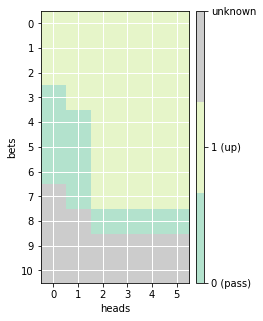

In [ ]:
# plot
policy_sarsamax = dict((k,np.argmax(v)) for k, v in Q_sarsamax.items())
plot_policy(policy_sarsamax)

# Remarks

* We can observe that the number of pass actions increase when the bets are bigger than the actual number of heads. This is expected since we are more confident in the game issue. 
* In general , the states with bets bigger than 8 are not explored , since the game stops just before the bets number become much more important the number of heads. 
* There is a difference in policy between Q-learning and Sarsa from one hand , and Mc-control from the other. In particular , the main difference is when the number of heads is bigger or equal to 3.  For MC , we don't explore enough the highest number of bets and this problem is less significant for q-learning and Sarsa. To palliate to this issue , we can try to modify the epsilon value or even change the exploration-exploitation strategy (by choosing for instance UBC).
* The execution time is lower for q-learning and similar between sarsa and MC-control. One possible reason for this is that the number of states and their possible actions is small , so executing an episode does not take much time. 
* The value of $\alpha$ influences the results, higher values can result in important changes in the policy and the model can even diverge for extreme values.  